In [1]:

import torch 
import torch.nn as nn
from torch.distributions import MultivariateNormal
import torch.optim as optim

from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm,trange
import time
# import seaborn as sns
plt.style.use('figures/images_style.mplstyle')

import numpy as np



# from mmnn import MMNN_UQ


In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:1


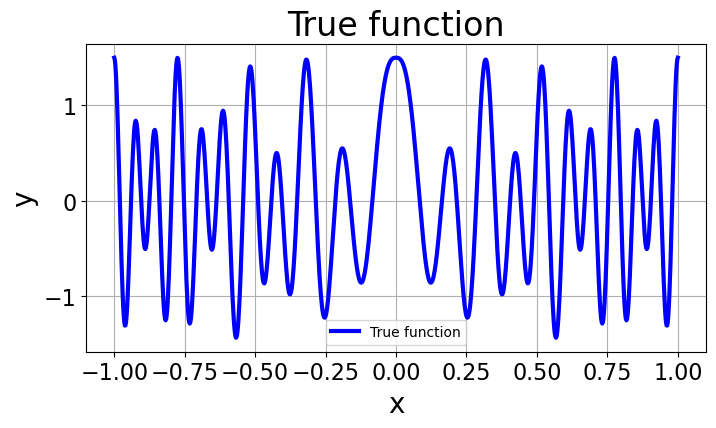

In [3]:
func = lambda x: torch.cos(20*torch.pi*torch.abs(x)**(1.4))+0.5*torch.cos(12*torch.pi*torch.abs(x)**(1.6))
size_data_set = 1000
x = torch.linspace(-1, 1, size_data_set, device=device).view(-1, 1)
y_true = func(x).view(-1, 1)   

# Plot trainig data
plt.figure(figsize=(8, 4))
plt.plot(x.cpu().numpy(), y_true.cpu().numpy(), label='True function', color='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.title('True function')
plt.legend()
plt.grid()


# MMNN UQ fixed sigma

In [ ]:
# class MMNN_UQ(nn.Module):
#     def __init__(self, 
#                  ranks = [1] + [16]*5 + [1], 
#                  widths = [366]*6,
#                  device = "cpu", 
#                  sigma = 0.01,
#                  ResNet = False,
#                  fixWb = True):
#         super().__init__()
#         """
#         A class to configure the neural network model.
    
#         Attributes:
#             ranks (list[int]): A list where the i-th element represents the output dimension of the i-th layer.
#                                For the j-th layer, ranks[j-1] is the input dimension and ranks[j] is the output dimension.
            
#             widths (list[int]): A list where each element specifies the width of the corresponding layer.
            
#             device (str): The device (CPU/GPU) on which the PyTorch code will be executed.
            
#             ResNet (bool): Indicates whether to use ResNet architecture, which includes identity connections between layers.
            
#             fixWb (bool): If True, the weights and biases are not updated during training.
#         """
        
#         self.ranks = ranks
#         self.widths = widths
#         self.ResNet = ResNet
#         self.depth = len(widths)
        
#         fc_sizes = [ ranks[0] ] 
#         for j in range(self.depth):
#             fc_sizes += [ widths[j], ranks[j+1] ]

#         fcs=[]
#         for j in range(len(fc_sizes)-1):
#             fc = nn.Linear(fc_sizes[j],
#                            fc_sizes[j+1], device=device) 
            
#             # setattr(self, f"fc{j}", fc)
#             fcs.append(fc)
#         self.fcs = nn.ModuleList(fcs)
        
#         if fixWb:
#             for j in range(len(fcs)):
#                 if j % 2 == 0:
#                     self.fcs[j].weight.requires_grad = False
#                     self.fcs[j].bias.requires_grad = False
#                     # #For the last fixed layer
#                     if j == len(fcs)-2:
#                     # # Fix the first layer
#                     # if j == 0:
#                         # print(f"Setting fixed weights and biases for layer {j} with sigma={sigma}")
#                         self.sampler_W = MultivariateNormal(
#                             loc = self.fcs[j].weight.view(-1),  
#                             covariance_matrix = sigma**2 * torch.eye(self.fcs[j].weight.numel(), device=device)
#                         )
#                         self.sampler_b = MultivariateNormal(
#                             loc = self.fcs[j].bias.view(-1),  
#                             covariance_matrix = sigma**2 * torch.eye(self.fcs[j].bias.numel(), device=device)
#                         )
                    
               
  

#     def forward(self, x):
#         for j in range(self.depth):
#             if self.ResNet:
#                 if 0 < j < self.depth-1:
#                     x_id = x + 0
#             # #Sample weights and biases for the last fixed layer and 
#             if 2*j == len(self.fcs)-2:
#             # # Sample weights and biases for the first fixed layer
#             # if 2*j == 0:
#                 weight_sample = self.sampler_W.sample().view(self.fcs[2*j].weight.shape)
#                 bias_sample = self.sampler_b.sample()
#                 x = torch.matmul(x, weight_sample.t()) + bias_sample
#                 # x = self.fcs[2*j](x)
#             else:
#                 x = self.fcs[2*j](x)
#             x = torch.relu(x)
#             x = self.fcs[2*j+1](x) 
#             if self.ResNet:
#                 if 0 < j < self.depth-1:
#                     n = min(x.shape[1], x_id.shape[1])
#                     x[:,:n] = x[:,:n] + x_id[:,:n]
#         return x

# MMNN UQ trainable sigma

In [ ]:
# class MMNN_UQ(nn.Module):
#     def __init__(self, 
#                  ranks = [1] + [16]*5 + [1], 
#                  widths = [366]*6,
#                  device = "cpu", 
#                  sigma = 0.01,
#                  ResNet = False,
#                  fixWb = True):
#         super().__init__()
#         """
#         A class to configure the neural network model.
    
#         Attributes:
#             ranks (list[int]): A list where the i-th element represents the output dimension of the i-th layer.
#                                For the j-th layer, ranks[j-1] is the input dimension and ranks[j] is the output dimension.
            
#             widths (list[int]): A list where each element specifies the width of the corresponding layer.
            
#             device (str): The device (CPU/GPU) on which the PyTorch code will be executed.
            
#             ResNet (bool): Indicates whether to use ResNet architecture, which includes identity connections between layers.
            
#             fixWb (bool): If True, the weights and biases are not updated during training.
#         """
        
#         self.ranks = ranks
#         self.widths = widths
#         self.ResNet = ResNet
#         self.depth = len(widths)

#         self.max_sigma = sigma

#         self.sigma_net = nn.Sequential(
#             nn.Linear(ranks[0], 32),
#             nn.ReLU(),
#             nn.Linear(32, 1),
#             nn.Sigmoid()  # Output between 0 and 1
#         ).to(device)
        
#         # Initialize the sigma network weights
#         for layer in self.sigma_net:
#             if isinstance(layer, nn.Linear):
#                 nn.init.zeros_(layer.weight)
#                 if layer.bias is not None:
#                     nn.init.ones_(layer.bias)#*10000

#         fc_sizes = [ ranks[0] ] 
#         for j in range(self.depth):
#             fc_sizes += [ widths[j], ranks[j+1] ]

#         fcs=[]
#         for j in range(len(fc_sizes)-1):
#             fc = nn.Linear(fc_sizes[j],
#                            fc_sizes[j+1], device=device) 
            
#             # setattr(self, f"fc{j}", fc)
#             fcs.append(fc)
#         self.fcs = nn.ModuleList(fcs)
        
#         if fixWb:
#             for j in range(len(fcs)):
#                 if j % 2 == 0:
#                     self.fcs[j].weight.requires_grad = False
#                     self.fcs[j].bias.requires_grad = False
#                     # For the last fixed layer
#                     if j == len(fcs)-2:
#                     # # Fix the first layer
#                     # if j == 0:
#                         # print(f"Setting fixed weights and biases for layer {j} with sigma={sigma}")
#                         self.sampler_W = MultivariateNormal(
#                             loc = self.fcs[j].weight.view(-1),  
#                             covariance_matrix =  torch.eye(self.fcs[j].weight.numel(), device=device)
#                         )
#                         self.sampler_b = MultivariateNormal(
#                             loc = self.fcs[j].bias.view(-1),  
#                             covariance_matrix = torch.eye(self.fcs[j].bias.numel(), device=device)
#                         )
                    
               
  

#     def forward(self, x,sigma_val = False):
#         sigma_x = self.sigma_net(x)*self.max_sigma  # Shape: (batch_size, 1)

#         for j in range(self.depth):
#             if self.ResNet:
#                 if 0 < j < self.depth-1:
#                     x_id = x + 0
            
#             # if 2*j == 0:
#             if 2*j == len(self.fcs)-2:
#                 W = self.fcs[2*j].weight
#                 b = self.fcs[2*j].bias
#                 batch_size = x.shape[0]
#                 sample_w = torch.randn(batch_size, W.shape[0]*W.shape[1], device=x.device) * sigma_x #[bs, W.shape[0]*W.shape[1]
#                 sample_w = sample_w.view(batch_size, W.shape[0], W.shape[1])  # Reshape to match W
#                 sample_b = torch.randn(batch_size, b.shape[0], device=x.device) * sigma_x

#                 # Expand W and b for each sample in the batch
#                 W = W.unsqueeze(0).expand(batch_size, -1, -1) + sample_w # [bs, W.shape[0], W.shape[1]]
#                 b = b.unsqueeze(0).expand(batch_size, -1) + sample_b # [bs, b.shape[0]]

#                 # x is of shape [bs, W.shape[1]]
#                 # W is of shape [bs, W.shape[0], W.shape[1]]
#                 # b is of shape [bs, b.shape[0]]
#                 x = torch.bmm(x.unsqueeze(1), W.transpose(1, 2)).squeeze(1) + b # [bs, W.shape[0]]
                
#             else:
#                 x = self.fcs[2*j](x)
#             x = torch.relu(x)
#             x = self.fcs[2*j+1](x) 
#             if self.ResNet:
#                 if 0 < j < self.depth-1:
#                     n = min(x.shape[1], x_id.shape[1])
#                     x[:,:n] = x[:,:n] + x_id[:,:n]
#         if sigma_val:
#             return x, sigma_x
#         else:   
#             return x




In [5]:
def visualize_discriminator_state(discriminator, model, inputs, targets, device, epoch, phase):
    """
    Comprehensive discriminator visualization
    """
    with torch.no_grad():
        # Get model outputs
        outputs = model(inputs)
        errors = torch.abs(outputs - targets)
        sigma_pred = model.sigma_net(inputs)
        
        # Create real and fake data
        real_data = torch.cat([inputs, errors, errors], dim=1)
        fake_data = torch.cat([inputs, sigma_pred, errors], dim=1)
        
        # Get discriminator outputs
        d_real = torch.sigmoid(discriminator(real_data))
        d_fake = torch.sigmoid(discriminator(fake_data))
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle(f'Discriminator Analysis - {phase} Epoch {epoch}', fontsize=16)
        
        # 1. Output Distribution
        axes[0,0].hist(d_real.cpu().numpy(), bins=30, alpha=0.7, label='Real Data', color='green')
        axes[0,0].hist(d_fake.cpu().numpy(), bins=30, alpha=0.7, label='Fake Data', color='red')
        axes[0,0].set_title('Discriminator Output Distribution')
        axes[0,0].set_xlabel('Discriminator Output')
        axes[0,0].set_ylabel('Frequency')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # 2. Calibration Quality vs Discriminator Response
        sigma_vals = sigma_pred.cpu().numpy().flatten()
        error_vals = errors.cpu().numpy().flatten()
        d_fake_vals = d_fake.cpu().numpy().flatten()
        
        # Color points by discriminator output
        scatter = axes[0,1].scatter(sigma_vals, error_vals, c=d_fake_vals, 
                                   cmap='RdYlGn', alpha=0.6, s=20)
        axes[0,1].plot([0, max(sigma_vals.max(), error_vals.max())], 
                      [0, max(sigma_vals.max(), error_vals.max())], 
                      'k--', alpha=0.5, label='Perfect Calibration')
        axes[0,1].set_title('Calibration Quality (Color = D(fake))')
        axes[0,1].set_xlabel('Predicted Sigma')
        axes[0,1].set_ylabel('Actual Error')
        axes[0,1].legend()
        plt.colorbar(scatter, ax=axes[0,1], label='D(fake)')
        
        # 3. Discriminator Accuracy
        d_real_binary = (d_real > 0.5).float()
        d_fake_binary = (d_fake < 0.5).float()
        acc_real = d_real_binary.mean().item()
        acc_fake = d_fake_binary.mean().item()
        overall_acc = (acc_real + acc_fake) / 2
        
        categories = ['Real Data\nAccuracy', 'Fake Data\nAccuracy', 'Overall\nAccuracy']
        accuracies = [acc_real, acc_fake, overall_acc]
        colors = ['green', 'red', 'blue']
        
        bars = axes[0,2].bar(categories, accuracies, color=colors, alpha=0.7)
        axes[0,2].set_title('Discriminator Classification Accuracy')
        axes[0,2].set_ylabel('Accuracy')
        axes[0,2].set_ylim(0, 1)
        axes[0,2].grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, acc in zip(bars, accuracies):
            axes[0,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                          f'{acc:.3f}', ha='center', va='bottom')
        
        # 4. Input Space Analysis (for 1D inputs)
        if inputs.shape[1] == 1:
            x_test = torch.linspace(inputs.min(), inputs.max(), 100, device=device).view(-1, 1)
            y_test = model(x_test)
            errors_test = torch.abs(y_test - func(x_test))  # Assume func is available
            sigma_test = model.sigma_net(x_test)
            
            # Test with perfect calibration
            perfect_data = torch.cat([x_test, errors_test, errors_test], dim=1)
            d_perfect = torch.sigmoid(discriminator(perfect_data))
            
            # Test with current predictions
            current_data = torch.cat([x_test, sigma_test, errors_test], dim=1)
            d_current = torch.sigmoid(discriminator(current_data))
            
            x_np = x_test.cpu().numpy().flatten()
            axes[1,0].plot(x_np, d_perfect.cpu().numpy().flatten(), 
                          label='Perfect Calibration', color='green', linewidth=2)
            axes[1,0].plot(x_np, d_current.cpu().numpy().flatten(), 
                          label='Current Predictions', color='red', linewidth=2)
            axes[1,0].set_title('Discriminator Response Across Input Space')
            axes[1,0].set_xlabel('Input x')
            axes[1,0].set_ylabel('D(x, σ, error)')
            axes[1,0].legend()
            axes[1,0].grid(True, alpha=0.3)
        
        # 5. Sigma vs Error Heatmap
        if len(sigma_vals) > 50:  # Only if we have enough data
            # Create 2D histogram
            sigma_range = np.linspace(0, sigma_vals.max(), 20)
            error_range = np.linspace(0, error_vals.max(), 20)
            
            # Bin the data and compute mean discriminator response
            from scipy.stats import binned_statistic_2d
            
            d_mean, x_edges, y_edges, _ = binned_statistic_2d(
                sigma_vals, error_vals, d_fake_vals, 
                statistic='mean', bins=[15, 15])
            
            im = axes[1,1].imshow(d_mean.T, origin='lower', cmap='RdYlGn', 
                                 extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                                 aspect='auto', alpha=0.8)
            axes[1,1].plot([0, max(sigma_vals.max(), error_vals.max())], 
                          [0, max(sigma_vals.max(), error_vals.max())], 
                          'k--', alpha=0.8, linewidth=2, label='Perfect Calibration')
            axes[1,1].set_title('Discriminator Heatmap')
            axes[1,1].set_xlabel('Predicted Sigma')
            axes[1,1].set_ylabel('Actual Error')
            axes[1,1].legend()
            plt.colorbar(im, ax=axes[1,1], label='Mean D(fake)')
        
        # 6. Training Statistics
        stats_text = f"""Training Statistics:
        
Real Data:
  Mean Output: {d_real.mean():.3f}
  Std Output:  {d_real.std():.3f}
  
Fake Data:
  Mean Output: {d_fake.mean():.3f}
  Std Output:  {d_fake.std():.3f}
  
Calibration:
  Mean |σ - error|: {torch.abs(sigma_pred.squeeze() - errors).mean():.4f}
  MSE(σ, error):    {torch.mean((sigma_pred.squeeze() - errors)**2):.4f}
        """
        
        axes[1,2].text(0.05, 0.95, stats_text, transform=axes[1,2].transAxes,
                      fontsize=10, verticalalignment='top', fontfamily='monospace',
                      bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
        axes[1,2].set_title('Training Statistics')
        axes[1,2].axis('off')
        
        plt.tight_layout()
        plt.show()

def track_discriminator_metrics(discriminator, model, test_loader, device):
    """
    Track key discriminator metrics over time
    """
    discriminator.eval()
    model.eval()
    
    total_acc_real = 0
    total_acc_fake = 0
    total_samples = 0
    calibration_errors = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            errors = torch.abs(outputs - targets)
            sigma_pred = model.sigma_net(inputs)
            
            # Real and fake data
            real_data = torch.cat([inputs, errors, errors], dim=1)
            fake_data = torch.cat([inputs, sigma_pred, errors], dim=1)
            
            # Discriminator outputs
            d_real = torch.sigmoid(discriminator(real_data))
            d_fake = torch.sigmoid(discriminator(fake_data))
            
            # Accuracy calculations
            acc_real = (d_real > 0.5).float().mean()
            acc_fake = (d_fake < 0.5).float().mean()
            
            total_acc_real += acc_real * inputs.size(0)
            total_acc_fake += acc_fake * inputs.size(0)
            total_samples += inputs.size(0)
            
            # Calibration error
            cal_error = torch.abs(sigma_pred.squeeze() - errors).mean()
            calibration_errors.append(cal_error.item())
    
    metrics = {
        'discriminator_acc_real': total_acc_real / total_samples,
        'discriminator_acc_fake': total_acc_fake / total_samples,
        'discriminator_acc_overall': (total_acc_real + total_acc_fake) / (2 * total_samples),
        'mean_calibration_error': np.mean(calibration_errors)
    }
    
    return metrics

In [ ]:

class MMNN_UQ(nn.Module):
    def __init__(self, 
                 ranks = [1] + [16]*5 + [1], 
                 widths = [366]*6,
                 device = "cpu", 
                 sigma = 0.01,
                 ResNet = False,
                 fixWb = True,
                 perturb_layer_idx = -1):
        super().__init__()
        """
        A class to configure the neural network model with configurable uncertainty quantification.
    
        Attributes:
            ranks (list[int]): A list where the i-th element represents the output dimension of the i-th layer.
                               For the j-th layer, ranks[j-1] is the input dimension and ranks[j] is the output dimension.
            
            widths (list[int]): A list where each element specifies the width of the corresponding layer.
            
            device (str): The device (CPU/GPU) on which the PyTorch code will be executed.
            
            sigma (float): Maximum value for the adaptive noise scaling parameter.
            
            ResNet (bool): Indicates whether to use ResNet architecture, which includes identity connections between layers.
            
            fixWb (bool): If True, the weights and biases are not updated during training.
            
            perturb_layer_idx (int): Index of the fixed layer to apply Gaussian perturbations to.
                                   - If -1 (default): Uses the last fixed layer (original behavior)
                                   - If >= 0: Uses the specified fixed layer index (0-indexed among fixed layers)
                                   - Must be within valid range of fixed layers
        """
        
        self.ranks = ranks
        self.widths = widths
        self.ResNet = ResNet
        self.depth = len(widths)
        self.fixWb = fixWb
        self.max_sigma = sigma

        # Build the network architecture
        fc_sizes = [ranks[0]] 
        for j in range(self.depth):
            fc_sizes += [widths[j], ranks[j+1]]

        fcs = []
        for j in range(len(fc_sizes)-1):
            fc = nn.Linear(fc_sizes[j], fc_sizes[j+1], device=device) 
            fcs.append(fc)
        self.fcs = nn.ModuleList(fcs)
        
        # Initialize the sigma network for adaptive noise
        self.sigma_net = nn.Sequential(
            nn.Linear(ranks[0], 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()  # Output between 0 and 1
        ).to(device)
        
        # Initialize the sigma network weights
        for layer in self.sigma_net:
            if isinstance(layer, nn.Linear):
                nn.init.zeros_(layer.weight) 
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

        # Determine which layers are fixed and handle perturbation layer selection
        self.fixed_layer_indices = []
        self.perturbed_layer_global_idx = None
        self.sampler_W = None
        self.sampler_b = None
        
        if fixWb:
            # Identify fixed layers (even indices: W layers)
            for j in range(len(fcs)):
                if j % 2 == 0:
                    self.fixed_layer_indices.append(j)
                    self.fcs[j].weight.requires_grad = False
                    self.fcs[j].bias.requires_grad = False
            
            # Validate and set perturbation layer
            num_fixed_layers = len(self.fixed_layer_indices)
            if num_fixed_layers == 0:
                raise ValueError("No fixed layers available for perturbation when fixWb=True")
            
            if perturb_layer_idx == -1:
                # Default: use last fixed layer (original behavior)
                self.perturbed_layer_idx = num_fixed_layers - 1
            else:
                if not (0 <= perturb_layer_idx < num_fixed_layers):
                    raise ValueError(f"perturb_layer_idx must be between 0 and {num_fixed_layers-1}, got {perturb_layer_idx}")
                self.perturbed_layer_idx = perturb_layer_idx
            
            # Get the global index of the layer to be perturbed
            self.perturbed_layer_global_idx = self.fixed_layer_indices[self.perturbed_layer_idx]
            
                        
            print(f"Perturbations will be applied to fixed layer {self.perturbed_layer_idx} "
                  f"(global index {self.perturbed_layer_global_idx})")
        else:
            print("Warning: fixWb=False, no layers will be perturbed")

    def get_perturbation_info(self):
        """
        Returns information about the perturbation configuration.
        
        Returns:
            dict: Contains information about fixed layers and perturbation settings
        """
        return {
            'num_fixed_layers': len(self.fixed_layer_indices),
            'fixed_layer_global_indices': self.fixed_layer_indices,
            'perturbed_layer_fixed_idx': self.perturbed_layer_idx if self.fixWb else None,
            'perturbed_layer_global_idx': self.perturbed_layer_global_idx,
            'fixWb': self.fixWb
        }

    def forward(self, x, sigma_val=False):
        """
        Forward pass with configurable layer perturbation.
        
        Args:
            x: Input tensor
            sigma_val: If True, returns both output and sigma values
            
        Returns:
            If sigma_val=False: output tensor
            If sigma_val=True: tuple of (output tensor, sigma tensor)
        """
        sigma_x = self.sigma_net(x) * self.max_sigma  # Shape: (batch_size, 1)

        for j in range(self.depth):
            if self.ResNet:
                if 0 < j < self.depth-1:
                    x_id = x + 0
            
            # Check if this is the layer to be perturbed
            current_global_idx = 2 * j
            if (self.fixWb and 
                self.perturbed_layer_global_idx is not None and 
                current_global_idx == self.perturbed_layer_global_idx):
                
                # Apply Gaussian perturbations to this layer
                W = self.fcs[current_global_idx].weight
                b = self.fcs[current_global_idx].bias
                batch_size = x.shape[0]
                
                # Generate noise scaled by learned sigma
                sample_w = torch.randn(batch_size, W.shape[0]*W.shape[1], device=x.device) * sigma_x
                sample_w = sample_w.view(batch_size, W.shape[0], W.shape[1])
                sample_b = torch.randn(batch_size, b.shape[0], device=x.device) * sigma_x

                # Apply perturbations
                W_perturbed = W.unsqueeze(0).expand(batch_size, -1, -1) + sample_w
                b_perturbed = b.unsqueeze(0).expand(batch_size, -1) + sample_b

                # Batched matrix multiplication
                x = torch.bmm(x.unsqueeze(1), W_perturbed.transpose(1, 2)).squeeze(1) + b_perturbed
            else:
                # Standard linear layer (no perturbation)
                x = self.fcs[current_global_idx](x)
            
            # Apply activation
            x = torch.relu(x)
            
            # Apply second linear layer of the block
            x = self.fcs[current_global_idx + 1](x) 
            
            # ResNet connection if enabled
            if self.ResNet:
                if 0 < j < self.depth-1:
                    n = min(x.shape[1], x_id.shape[1])
                    x[:,:n] = x[:,:n] + x_id[:,:n]
        
        if sigma_val:
            return x, sigma_x
        else:   
            return x

In [8]:
num_epochs = 10_000
batch_size = 100
num_training_samples = 1000 # uniform grid samples
num_test_samples = 1234 # random samples

In [9]:
# learning rate in epoch k is 
# lr_init*lr_gamma**floor(k/lr_step_size)
lr_init=0.001
lr_gamma=0.9
lr_step_size= 400

In [140]:
# to monitor the training process.
show_plot = True 
max_sigma = 0.01
interval=[-1,1]
ranks = [1] + [16]*5 + [1]
widths = [360]*6
model = MMNN_UQ(ranks = ranks, 
                 widths = widths,
                 device = device,
                 sigma = max_sigma,
                 ResNet = False,
                 perturb_layer_idx= -1)  # Use -1 for last fixed layer by default

# Test evaluation
def learned_nn(x):
    x = x.reshape([-1, 1]) 
    y = model(x)
    return y 

Perturbations will be applied to fixed layer 5 (global index 10)


In [141]:
x_train = torch.linspace(*interval, num_training_samples,device=device).reshape([-1, 1])
y_train = func(x_train)
# x_train = torch.tensor(x_train, device=device, dtype=mydtype)
# y_train = torch.tensor(y_train, device=device, dtype=mydtype)
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size, shuffle=True)

In [142]:

errors_train=[]
errors_test=[]
errors_test_max=[]

optimizer = optim.Adam(model.parameters(), lr=lr_init)
scheduler = StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)
criterion = nn.MSELoss()



# Training fixed sigma

In [143]:
# time1=time.time()
# for epoch in range(1,1+num_epochs):
#     for inputs, targets in train_loader:
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, targets)
#         loss.backward()
#         optimizer.step()
    
#     scheduler.step()
              
#     if epoch % 1000 == 0:
#         training_error = loss.item()
#         print(f"\nEpoch {epoch} / {num_epochs}" + 
#               f"  ( {epoch/num_epochs*100:.2f}% )" +
#               f"\nTraining error (MSE): { training_error :.2e}" + 
#               f"\nTime used: { time.time() - time1 :.2f}s")
#         errors_train.append(training_error)
    
#         def learned_nn(x): # input and output are numpy.ndarray  
#             x=x.reshape([-1, 1]) 
#             input_data =x # torch.tensor(x, dtype=mydtype).to(device)
#             y = model(input_data)
#             y = y#.cpu().detach().numpy().reshape([-1])
#             return y     
        
        
#         x = torch.rand(num_test_samples, 1, device=device) * 2 - 1
#         x = x.reshape([-1, 1])
#         y_nn = learned_nn(x)
#         y_true = func(x)
        
#         # Calculate errors
#         e = y_nn - y_true
#         e_max = torch.max(torch.abs(e))
#         e_mse = torch.mean(e**2)
#         errors_test.append(e_mse)
#         errors_test_max.append(e_max)
        
#         print("Test errors (MAX and MSE): " + 
#               f"{e_max:.2e} and {e_mse:.2e}")
        
#         if epoch % 100 == 0:
#             # Plot the results
#             x = torch.linspace(-1, 1, 1000,device=device)
#             y_nn = learned_nn(x)
#             y_true = func(x)
#             fig=plt.figure(figsize=(6,4))
#             plt.plot(x.detach().cpu().numpy(), y_true.detach().cpu().numpy(), label='true function')
#             plt.plot(x.detach().cpu().numpy(), y_nn.detach().cpu().numpy(), label='learned network')
#             plt.xticks(np.linspace(*interval,5))
#             plt.tick_params(axis='both', 
#                             which='major', labelsize=12)
#             plt.grid(True, axis='both', color='#AAAAAA', 
#                       linestyle='--', linewidth=1.4)
#             plt.title(f'true function and learned network in (Epoch {epoch})')
#             plt.tight_layout()
#             plt.legend(loc="upper center" , fontsize=13,  ncol=2,
#                 )
    
#             plt.show()

# Training sigma 1 

In [144]:
# discriminator = nn.Sequential(
#     nn.Linear(1 + 1 + 1, 32),  # input_dim + sigma + error
#     nn.ReLU(),
#     nn.Linear(32, 1),
#     nn.Sigmoid()
# ).to(device)

# time1=time.time()
# errors_train=[]
# errors_test=[]
# errors_test_max=[]

# opt_generator = optim.Adam(model.parameters(), lr=lr_init)
# opt_discriminator = optim.Adam(discriminator.parameters(), lr=lr_init)
# scheduler_G = StepLR(opt_generator, step_size=lr_step_size, gamma=lr_gamma)
# scheduler_D = StepLR(opt_discriminator, step_size=lr_step_size, gamma=lr_gamma)

# criterion = nn.MSELoss()
# bce_loss = nn.BCELoss()

# optimizer = optim.Adam(model.parameters(), lr=lr_init)
# scheduler = StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)
# criterion = nn.MSELoss()

# for epoch in range(1,1+num_epochs):
#     for inputs, targets in train_loader:
#         # STEP 1: Train Discriminator
#         opt_discriminator.zero_grad()
#         outputs = model(inputs)
#         errors = torch.abs(outputs - targets)
#         sigma_pred = model.sigma_net(inputs)
        
#         # Real data (assume perfect calibration: sigma* = error)
#         real_data = torch.cat([inputs, errors, errors], dim=1)  # (x, sigma*, error)
#         real_labels = torch.ones(inputs.size(0), 1, device=device)
        
#         # Fake data (our predictions)
#         fake_data = torch.cat([inputs, sigma_pred.detach(), errors], dim=1)  # (x, sigma, error)
#         fake_labels = torch.zeros(inputs.size(0), 1, device=device)
        
#         # Discriminator loss
#         d_real = discriminator(real_data)
#         d_fake = discriminator(fake_data)
#         loss_d = bce_loss(d_real, real_labels) + bce_loss(d_fake, fake_labels)
#         loss_d.backward()
#         opt_discriminator.step()
        
#         # STEP 2: Train Generator (MMNN + sigma_net)
#         opt_generator.zero_grad()
#         outputs = model(inputs)
#         sigma_pred = model.sigma_net(inputs)
#         errors = torch.abs(outputs - targets)
        
#         # Generator losses
#         fake_data = torch.cat([inputs, sigma_pred, errors], dim=1)
#         d_fake = discriminator(fake_data)
        
#         loss_pred = criterion(outputs, targets)  # Prediction loss
#         loss_adv = bce_loss(d_fake, real_labels)  # Fool discriminator
#         loss_reg = torch.mean(sigma_pred**2)  # Regularization
        
#         loss_g = loss_adv + 2.0*loss_pred #+ 0.1*loss_reg  # λ₁=1.0, λ₂=0.1
#         loss_g.backward()
#         opt_generator.step()
        
#     scheduler_G.step()
#     scheduler_D.step()
              
#     if epoch % 500 == 0:
#         training_error = loss_g.item()
#         print(f"\nEpoch {epoch} / {num_epochs}" + 
#               f"  ( {epoch/num_epochs*100:.2f}% )" +
#               f"\nTraining error (MSE): { training_error :.2e}" + 
#               f"\nTime used: { time.time() - time1 :.2f}s")
#         errors_train.append(training_error)
    
#         def learned_nn(x): # input and output are numpy.ndarray  
#             x=x.reshape([-1, 1]) 
#             input_data =x # torch.tensor(x, dtype=mydtype).to(device)
#             y = model(input_data)
#             y = y#.cpu().detach().numpy().reshape([-1])
#             return y     
        
        
#         x = torch.rand(num_test_samples, 1, device=device) * 2 - 1
#         x = x.reshape([-1, 1])
#         y_nn = learned_nn(x)
#         y_true = func(x)
        
#         # Calculate errors
#         e = y_nn - y_true
#         e_max = torch.max(torch.abs(e))
#         e_mse = torch.mean(e**2)
#         errors_test.append(e_mse)
#         errors_test_max.append(e_max)
        
#         print("Test errors (MAX and MSE): " + 
#               f"{e_max:.2e} and {e_mse:.2e}")
        
#         if epoch % 100 == 0:
#             # Plot the results
#             x = torch.linspace(-1, 1, 1000,device=device)
#             y_nn = learned_nn(x)
#             y_true = func(x)
#             fig=plt.figure(figsize=(6,4))
#             plt.plot(x.detach().cpu().numpy(), y_true.detach().cpu().numpy(), label='true function')
#             plt.plot(x.detach().cpu().numpy(), y_nn.detach().cpu().numpy(), label='learned network')
#             plt.xticks(np.linspace(*interval,5))
#             plt.tick_params(axis='both', 
#                             which='major', labelsize=12)
#             plt.grid(True, axis='both', color='#AAAAAA', 
#                       linestyle='--', linewidth=1.4)
#             plt.title(f'true function and learned network in (Epoch {epoch})')
#             plt.tight_layout()
#             plt.legend(loc="upper center" , fontsize=13,  ncol=2,
#                 )
    
#             plt.show()

# Training sigma 2

In [145]:
# # Initialize sigma network to output constant 0.01
# def init_sigma_network_constant(sigma_net, target_sigma=0.01):
#     """Initialize sigma network to output constant target_sigma"""
#     target_logit = torch.log(torch.exp(torch.tensor(target_sigma)) - 1)
    
#     with torch.no_grad():
#         # Zero out all weights and biases
#         for layer in sigma_net:
#             if isinstance(layer, nn.Linear):
#                 nn.init.zeros_(layer.weight)
#                 nn.init.zeros_(layer.bias)
        
#         # Set final layer bias to target value (before Softplus)
#         sigma_net[-2].bias.fill_(target_logit.item())

# # Apply initialization
# init_sigma_network_constant(model.sigma_net, target_sigma=0.01)

discriminator = nn.Sequential(
    nn.Linear(1 + 1 + 1, 32),  # input_dim + sigma + error
    nn.ReLU(),
    nn.Linear(32, 1),
    nn.Sigmoid()
).to(device)


In [146]:

# Training parameters
warmup_epochs = 500  # Phase 1: MMNN-only training
total_epochs = num_epochs

time1=time.time()
errors_train=[]
errors_test=[]
errors_test_max=[]

# Optimizers
opt_generator = optim.Adam(model.parameters(), lr=lr_init)
opt_discriminator = optim.Adam(discriminator.parameters(), lr=lr_init)
scheduler_G = StepLR(opt_generator, step_size=lr_step_size, gamma=lr_gamma)
scheduler_D = StepLR(opt_discriminator, step_size=lr_step_size, gamma=lr_gamma)

# Warmup optimizer (MMNN only, exclude sigma_net parameters)
mmnn_params = [p for n, p in model.named_parameters() if 'sigma_net' not in n]
opt_warmup = optim.Adam(mmnn_params, lr=lr_init)

criterion = nn.MSELoss()
bce_loss = nn.BCELoss()


In [147]:
# pbar = trange(warmup_epochs, desc="Warmup Training Progress", unit="epoch")
# model.max_sigma = 0
# for epoch in pbar:
#     # PHASE 1: Warmup training (MMNN only, fixed noise)
#     for inputs, targets in train_loader:
#         opt_warmup.zero_grad()
        
#         # Forward with fixed small noise (0.01)
#         outputs = model(inputs)  # This uses the initialized sigma ≈ 0.01
#         loss = criterion(outputs, targets)
        
#         loss.backward()
#         opt_warmup.step()
#     pbar.set_postfix({"epoch": epoch, "loss": loss.item()})
        
#     # Print warmup progress
#     if epoch % 100 == 0:
#         print(f"Warmup Epoch {epoch}/{warmup_epochs} - Loss: {loss.item():.4f}")

In [148]:
# pbar = trange(num_epochs, desc="Training Progress", unit="epoch")

# discriminator_steps = 20
# generator_steps = 20

# model.max_sigma = max_sigma  # Set max_sigma for GAN training
# for epoch in pbar:
    
#     # PHASE 2: GAN training (after warmup)
#     for inputs, targets in train_loader:
        
#         # STEP 1: Train Discriminator
#         opt_discriminator.zero_grad()
#         outputs = model(inputs)
#         errors = torch.abs(outputs - targets)
#         sigma_pred = model.sigma_net(inputs)
        
#         # Real data (perfect calibration: sigma* = error)
#         real_data = torch.cat([inputs, errors, errors], dim=1)
#         real_labels = torch.ones(inputs.size(0), 1, device=device)
        
#         # Fake data (our predictions)
#         fake_data = torch.cat([inputs, sigma_pred.detach(), errors], dim=1)
#         fake_labels = torch.zeros(inputs.size(0), 1, device=device)
        
            
#         # Discriminator loss
#         d_real = discriminator(real_data)
#         d_fake = discriminator(fake_data)
#         loss_d = bce_loss(d_real, real_labels) + bce_loss(d_fake, fake_labels)
#         # if epoch % 2 == 0:  # Update discriminator every 2 epochs
#         loss_d.backward()
#         opt_discriminator.step()
#         # else:
#         #     # Skip discriminator update for this epoch
#         #     loss_d = torch.tensor(0.0, device=device)
#         # STEP 2: Train Generator (MMNN + sigma_net)
#         opt_generator.zero_grad()
#         outputs = model(inputs)
#         sigma_pred = model.sigma_net(inputs)
#         errors = torch.abs(outputs - targets)
        
#         # Generator losses
#         fake_data = torch.cat([inputs, sigma_pred, errors], dim=1)
#         d_fake = discriminator(fake_data)
        
#         loss_pred = criterion(outputs, targets)
#         loss_adv = bce_loss(d_fake, real_labels)
#         loss_reg = torch.mean(sigma_pred**2)
        
#         # if epoch %2 == 1:
#         loss_g = loss_adv + 5.0*loss_pred #+ 0.1*loss_reg  # λ₁=1.0, λ₂=0.1
#         loss_g.backward()
#         opt_generator.step()
#         # else:
#         #     # Skip generator update for this epoch
#         #     loss_g = torch.tensor(0.0, device=device)
#     pbar.set_postfix({"epoch": epoch,
#                       "lr_g": scheduler_G.get_last_lr()[0],
#                       "lr_d": scheduler_D.get_last_lr()[0],
#                        "loss_g": loss_g.item(), 
#                        "loss_pred": loss_pred.item(),
#                           "loss_adv": loss_adv.item(),
#                             "loss_reg": loss_reg.item(),
#                        "loss_d": loss_d.item()})
#     scheduler_G.step()
#     scheduler_D.step()
    
#     # Evaluation and plotting (same for both phases)
#     if epoch % 500 == 0:
#         if epoch <= warmup_epochs:
#             training_error = loss.item()
#             print(f"\nWarmup Epoch {epoch}")
#         else:
#             training_error = loss_g.item()
#             print(f"\nGAN Epoch {epoch} / {total_epochs}")
            
#         print(f"  ( {epoch/total_epochs*100:.2f}% )" +
#               f"\nTraining error: {training_error:.2e}" + 
#               f"\nTime used: {time.time() - time1:.2f}s")
#         errors_train.append(training_error)
    
            
        
#         x = torch.rand(num_test_samples, 1, device=device) * 2 - 1
#         x = x.reshape([-1, 1])
#         y_nn = learned_nn(x)
#         y_true = func(x)
        
#         e = y_nn - y_true
#         e_max = torch.max(torch.abs(e))
#         e_mse = torch.mean(e**2)
#         errors_test.append(e_mse)
#         errors_test_max.append(e_max)
        
#         print("Test errors (MAX and MSE): " + 
#               f"{e_max:.2e} and {e_mse:.2e}")
        
#         # Plot results
#         if epoch % 100 == 0:
#             x = torch.linspace(-1, 1, 1000, device=device)
#             y_nn,sigma_nn = model(x.view(-1,1), sigma_val=True)
#             y_true = func(x)
            
#             fig = plt.figure(figsize=(6,4))
#             plt.plot(x.detach().cpu().numpy(), y_true.detach().cpu().numpy(), label='true function')
#             plt.plot(x.detach().cpu().numpy(), y_nn.detach().cpu().numpy(), label='learned network')
            
#             # Add uncertainty bounds if past warmup, do five predictions
            
#             sols = torch.zeros((10, x.size(0), 1), device=device)
#             for i in range(10):
#                 sols[i] = learned_nn(x)
            
#             mean_sol = sols.mean(dim=0)
#             std_sol = sols.std(dim=0)

#             y_upper = mean_sol + std_sol
#             y_lower = mean_sol - std_sol

#             plt.fill_between(x.detach().cpu().numpy(),
#                                 y_lower.detach().cpu().numpy().flatten(),
#                                 y_upper.detach().cpu().numpy().flatten(),
#                                 color='gray', alpha=1, label='Uncertainty bounds')

#             phase = "Warmup" if epoch <= warmup_epochs else "GAN"
#             plt.title(f'{phase} Training - Epoch {epoch}')
#             plt.grid(True)
#             plt.legend()
#             plt.show()

#             plt.plot(x.detach().cpu().numpy(), sigma_nn.detach().cpu().numpy())
#             plt.title('Learned Sigma Network Output')
#             plt.xlabel('Input x')
#             plt.ylabel('Sigma')
#             plt.grid(True)
#             plt.show()


Training Progress:   0%|          | 0/10000 [00:00<?, ?epoch/s, phase=Warmup, epoch=0, lr_g=0.001, lr_d=0, loss=0.664]/work/Sebas/miniconda3/envs/MMNN/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(



Warmup Epoch 0 / 10000
  ( 0.00% )
Training error: 6.64e-01
Time used: 77.72s
Test errors (MAX and MSE): 1.52e+00 and 6.36e-01


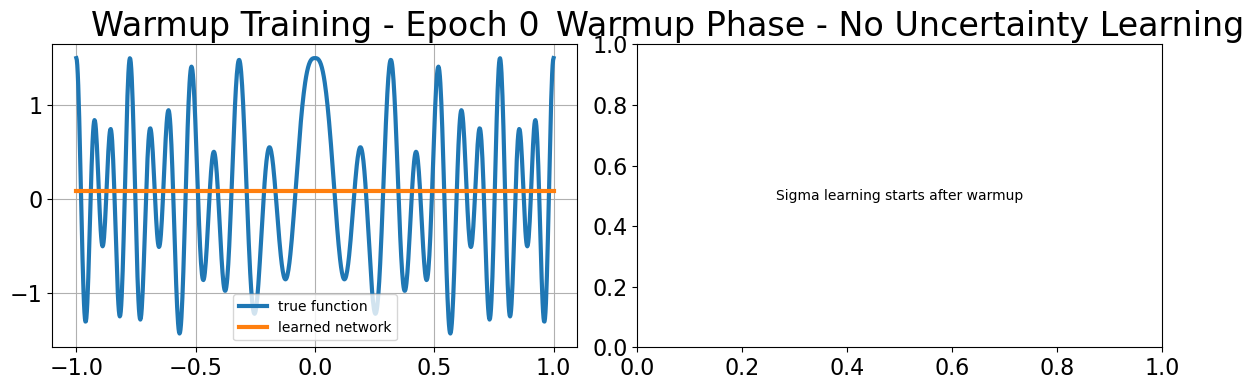

Training Progress:   5%|▌         | 504/10000 [00:20<06:46, 23.34epoch/s, phase=Warmup, epoch=504, lr_g=0.001, lr_d=0, loss=0.0064] 


Warmup Epoch 500 / 10000
  ( 5.00% )
Training error: 2.31e-02
Time used: 98.07s
Test errors (MAX and MSE): 4.98e-01 and 1.45e-02


Training Progress:  10%|█         | 1000/10000 [00:41<06:20, 23.67epoch/s, phase=Landscape Learning, epoch=1000, lr_g=0.001, lr_d=0.001, loss=1.69]


Landscape Learning Epoch 1000 / 10000
  ( 10.00% )
Training error: 1.69e+00
Time used: 118.86s
Test errors (MAX and MSE): 1.31e+00 and 2.02e-01


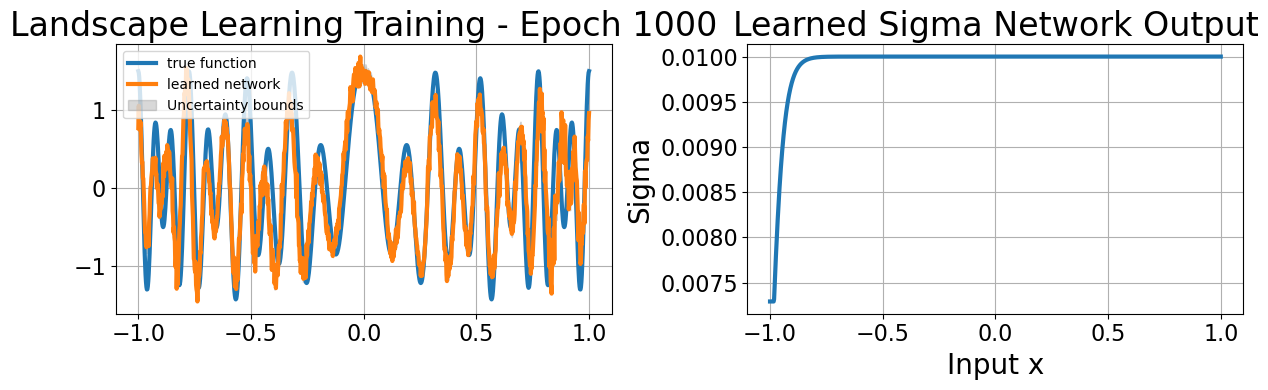

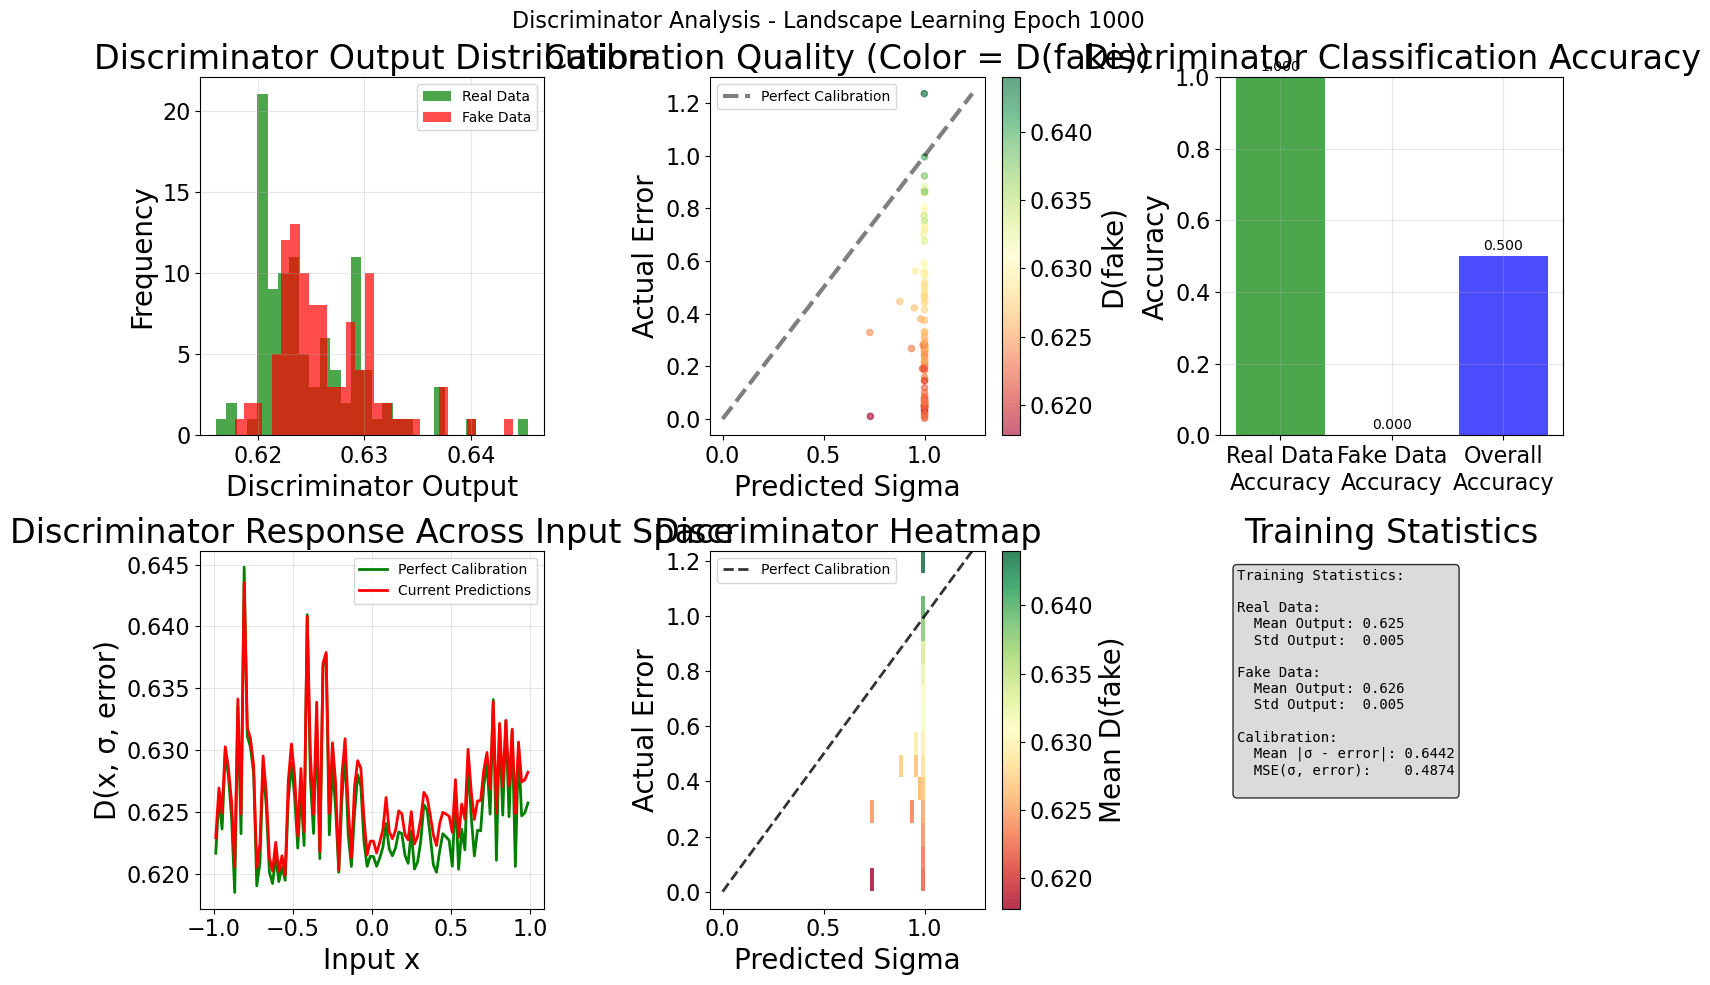

Training Progress:  15%|█▌        | 1502/10000 [01:37<16:12,  8.74epoch/s, phase=Adversarial, epoch=1501, lr_g=0.0009, lr_d=0.0009, loss=14.7]          


Adversarial Epoch 1500 / 10000
  ( 15.00% )
Training error: 5.24e+01
Time used: 174.76s
Test errors (MAX and MSE): 4.45e+00 and 1.75e+00


Training Progress:  20%|██        | 2000/10000 [02:34<15:27,  8.63epoch/s, phase=Adversarial, epoch=2000, lr_g=0.00081, lr_d=0.00081, loss=5.12]


Adversarial Epoch 2000 / 10000
  ( 20.00% )
Training error: 5.12e+00
Time used: 232.22s
Test errors (MAX and MSE): 1.84e+00 and 1.66e-01


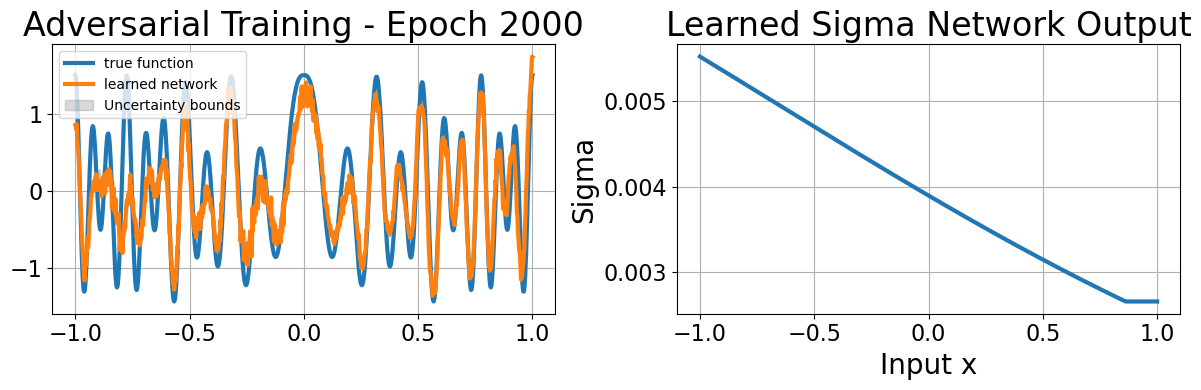

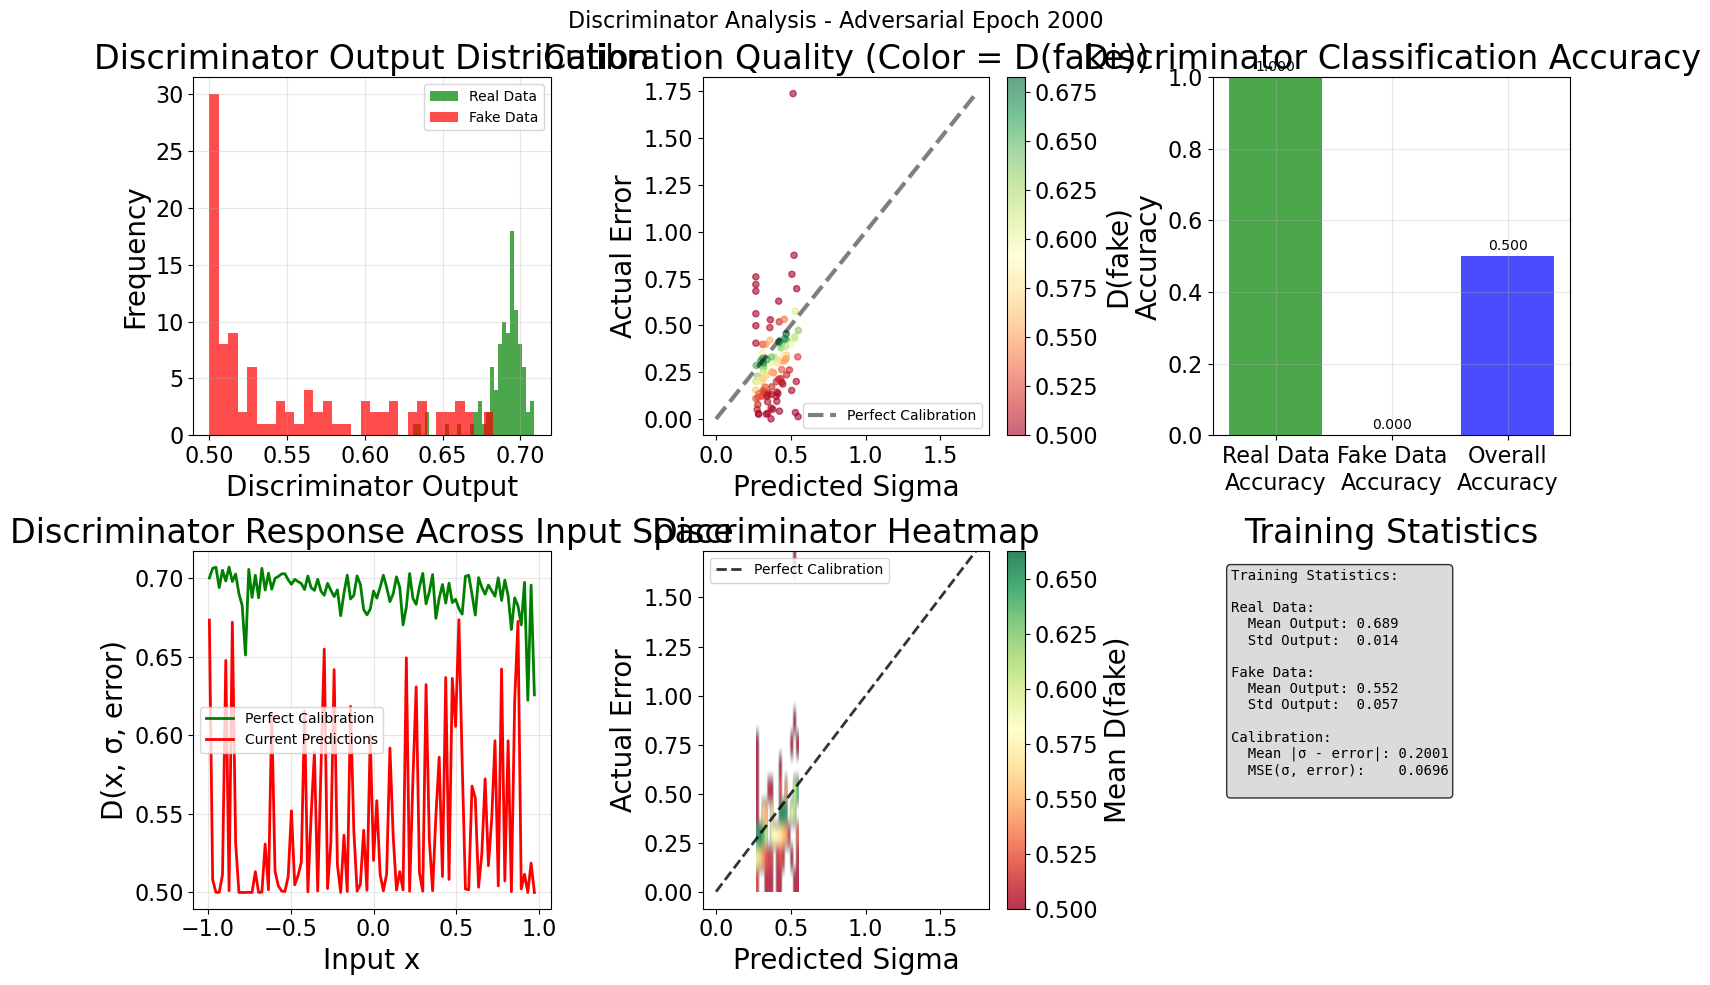

Training Progress:  25%|██▌       | 2502/10000 [03:33<14:21,  8.70epoch/s, phase=Adversarial, epoch=2501, lr_g=0.000729, lr_d=0.000729, loss=13.4]


Adversarial Epoch 2500 / 10000
  ( 25.00% )
Training error: 8.81e+00
Time used: 290.74s
Test errors (MAX and MSE): 1.09e+00 and 8.80e-02


Training Progress:  30%|███       | 3000/10000 [04:30<13:23,  8.71epoch/s, phase=Adversarial, epoch=3000, lr_g=0.00059, lr_d=0.00059, loss=21.8]  


Adversarial Epoch 3000 / 10000
  ( 30.00% )
Training error: 2.18e+01
Time used: 348.29s
Test errors (MAX and MSE): 1.54e+00 and 1.95e-01


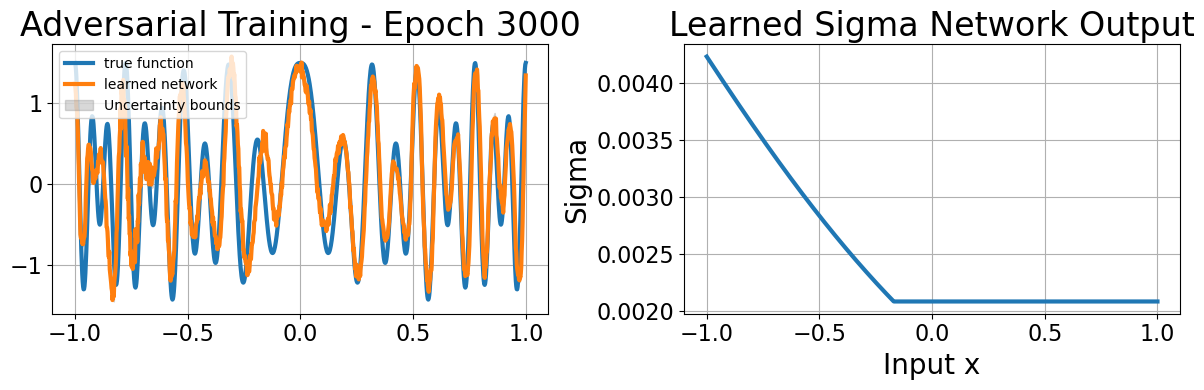

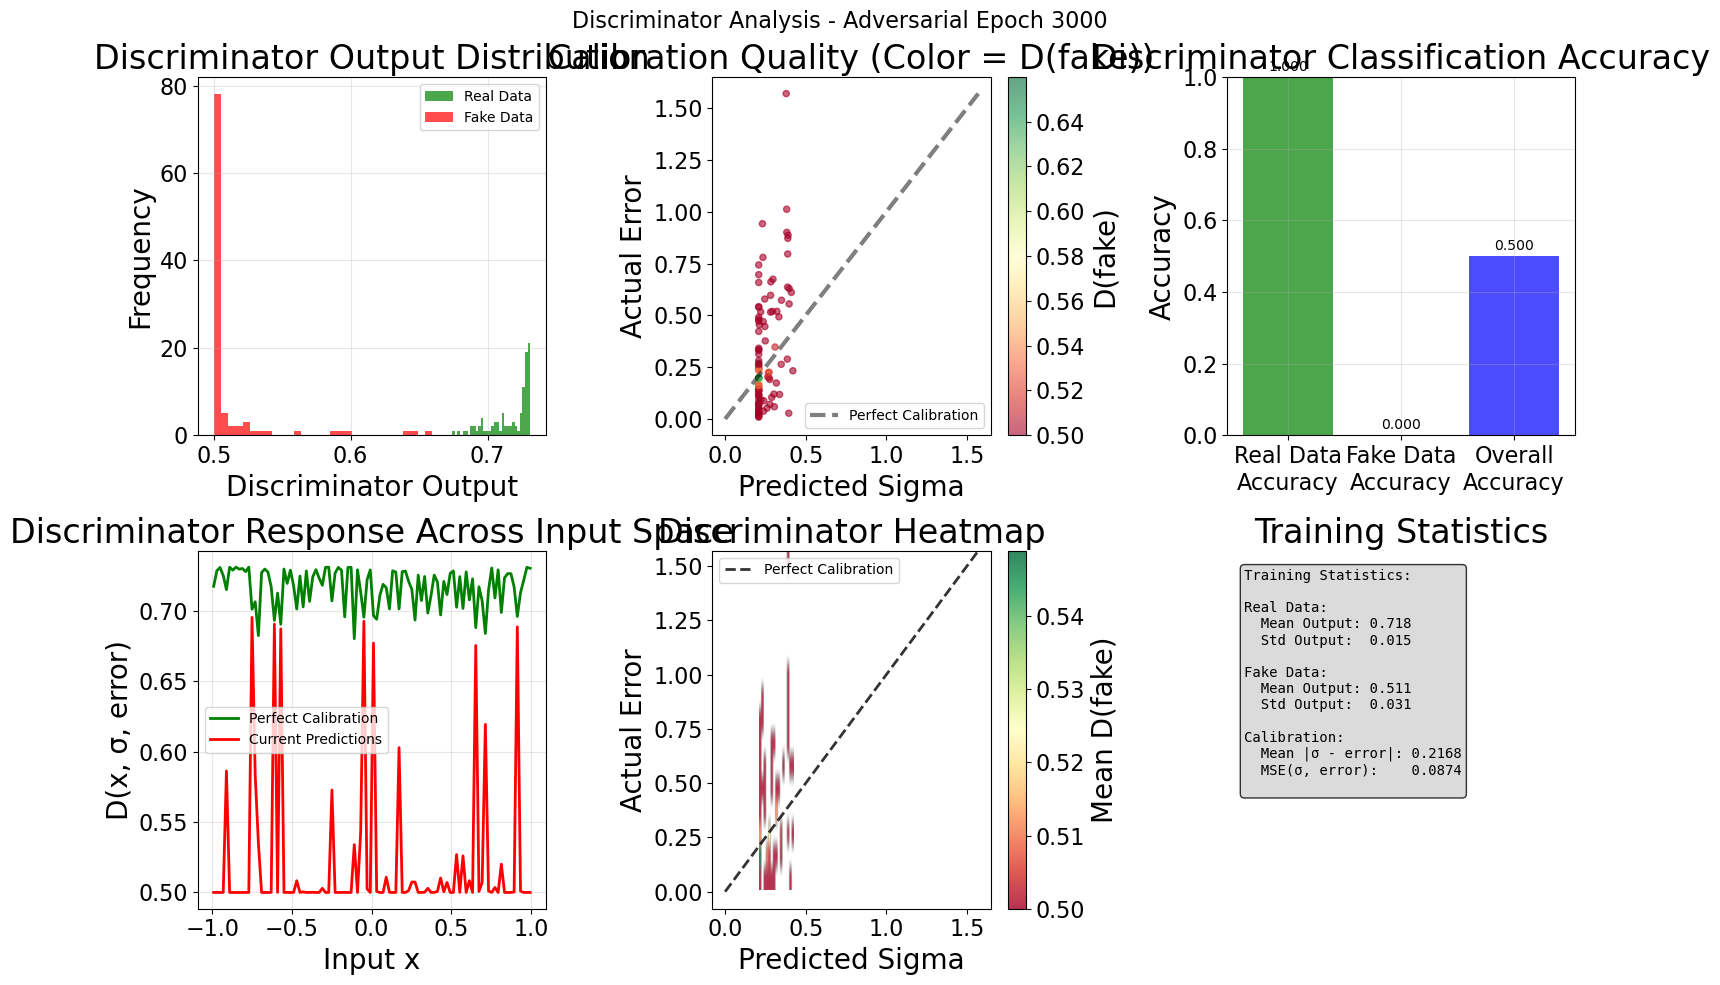

Training Progress:  31%|███▏      | 3140/10000 [04:47<10:28, 10.92epoch/s, phase=Adversarial, epoch=3139, lr_g=0.00059, lr_d=0.00059, loss=26.4]


KeyboardInterrupt: 

In [149]:
pbar = trange(num_epochs, desc="Training Progress", unit="epoch")
warmup_epochs = 1000  # Phase 1: Learn basic function approximation
landscape_epochs = 500  # Phase 2: Learn error landscape
total_epochs = num_epochs


warmup_scheduler = StepLR(opt_warmup, step_size=lr_step_size, gamma=lr_gamma)
for epoch in pbar:
    
    # PHASE 1: WARMUP - No noise, basic function learning
    if epoch < warmup_epochs:
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            
            # No perturbations during warmup
            model.max_sigma = 0.0  # Disable noise
            outputs = model(inputs)
            
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        
        training_error = loss.item()
        phase = "Warmup"
    
    # PHASE 2: ERROR LANDSCAPE LEARNING - Learn calibration without adversarial competition
    elif epoch < warmup_epochs + landscape_epochs:
        model.max_sigma = max_sigma  # Enable noise
        
        for inputs, targets in train_loader:
            # Train discriminator on real calibration examples
            opt_discriminator.zero_grad()
            
            outputs = model(inputs)
            errors = torch.abs(outputs - targets)
            sigma_pred = model.sigma_net(inputs)
            
            # Real data: perfect calibration
            real_data = torch.cat([inputs, errors, errors], dim=1)
            real_labels = torch.ones(inputs.size(0), 1, device=device)
            
            # Fake data: random/poor calibration (use random sigmas)
            random_sigma = torch.rand_like(sigma_pred) * max_sigma
            fake_data = torch.cat([inputs, random_sigma, errors], dim=1)
            fake_labels = torch.zeros(inputs.size(0), 1, device=device)
            
            # Discriminator loss
            d_real = discriminator(real_data)
            d_fake = discriminator(fake_data)
            loss_d = bce_loss(d_real, real_labels) + bce_loss(d_fake, fake_labels)
            loss_d.backward()
            opt_discriminator.step()
            
            # Train generator to predict good uncertainties (non-adversarial)
            opt_generator.zero_grad()
            
            outputs = model(inputs)
            errors = torch.abs(outputs - targets)
            sigma_pred = model.sigma_net(inputs)
            
            # Direct calibration loss: sigma should approximate error
            loss_pred = criterion(outputs, targets)
            loss_calibration = torch.mean((sigma_pred.squeeze() - errors)**2)
            loss_reg = torch.mean(sigma_pred**2)
            
            loss_g = 5.0*loss_pred + 1.0*loss_calibration + 0.1*loss_reg
            loss_g.backward()
            opt_generator.step()
        
        training_error = loss_g.item()
        phase = "Landscape Learning"
    
    # PHASE 3: ADVERSARIAL TRAINING - Full GAN training
    else:
        model.max_sigma = max_sigma  # Keep noise enabled
        
        for inputs, targets in train_loader:
            
            # STEP 1: Train Discriminator
            opt_discriminator.zero_grad()
            outputs = model(inputs)
            errors = torch.abs(outputs - targets)
            sigma_pred = model.sigma_net(inputs)
            
            # Real data (perfect calibration: sigma* = error)
            real_data = torch.cat([inputs, errors, errors], dim=1)
            real_labels = torch.ones(inputs.size(0), 1, device=device)
            
            # Fake data (our predictions)
            fake_data = torch.cat([inputs, sigma_pred.detach(), errors], dim=1)
            fake_labels = torch.zeros(inputs.size(0), 1, device=device)
            
            # Discriminator loss
            d_real = discriminator(real_data)
            d_fake = discriminator(fake_data)
            loss_d = bce_loss(d_real, real_labels) + bce_loss(d_fake, fake_labels)
            loss_d.backward()
            opt_discriminator.step()
            
            # STEP 2: Train Generator (MMNN + sigma_net)
            opt_generator.zero_grad()
            outputs = model(inputs)
            sigma_pred = model.sigma_net(inputs)
            errors = torch.abs(outputs - targets)
            
            # Generator losses
            fake_data = torch.cat([inputs, sigma_pred, errors], dim=1)
            d_fake = discriminator(fake_data)
            
            loss_pred = criterion(outputs, targets)
            loss_adv = bce_loss(d_fake, real_labels)
            loss_reg = torch.mean(sigma_pred**2)
            
            loss_g = loss_adv + 5.0*loss_pred + 0.1*loss_reg
            loss_g.backward()
            opt_generator.step()
        
        training_error = loss_g.item()
        phase = "Adversarial"
    
    # Update progress bar
    pbar.set_postfix({
        "phase": phase,
        "epoch": epoch,
        "lr_g": scheduler_G.get_last_lr()[0] if epoch >= warmup_epochs else optimizer.param_groups[0]['lr'],
        "lr_d": scheduler_D.get_last_lr()[0] if epoch >= warmup_epochs else 0.0,
        "loss": training_error
    })
    
    # Update schedulers based on phase
    if epoch < warmup_epochs:
        warmup_scheduler.step()  # Assume you have a warmup scheduler
    else:
        scheduler_G.step()
        scheduler_D.step()
    
    # Evaluation and plotting (same for all phases)
    if epoch % 500 == 0:
        print(f"\n{phase} Epoch {epoch} / {total_epochs}")
        print(f"  ( {epoch/total_epochs*100:.2f}% )")
        print(f"Training error: {training_error:.2e}")
        print(f"Time used: {time.time() - time1:.2f}s")
        errors_train.append(training_error)
        
        # Test evaluation
        x = torch.rand(num_test_samples, 1, device=device) * 2 - 1
        x = x.reshape([-1, 1])
        y_nn = learned_nn(x)
        y_true = func(x)
        
        e = y_nn - y_true
        e_max = torch.max(torch.abs(e))
        e_mse = torch.mean(e**2)
        errors_test.append(e_mse)
        errors_test_max.append(e_max)
        
        print("Test errors (MAX and MSE): " + 
              f"{e_max:.2e} and {e_mse:.2e}")
        
        # Plot results
        if epoch % 1000 == 0:
            x = torch.linspace(-1, 1, 1000, device=device)
            y_nn, sigma_nn = model(x.view(-1,1), sigma_val=True)
            y_true = func(x)
            
            fig = plt.figure(figsize=(12,4))
            
            # Main prediction plot
            plt.subplot(1, 2, 1)
            plt.plot(x.detach().cpu().numpy(), y_true.detach().cpu().numpy(), label='true function')
            plt.plot(x.detach().cpu().numpy(), y_nn.detach().cpu().numpy(), label='learned network')
            
            # Add uncertainty bounds if past warmup
            if epoch >= warmup_epochs:
                sols = torch.zeros((10, x.size(0), 1), device=device)
                for i in range(10):
                    sols[i] = learned_nn(x)
                
                mean_sol = sols.mean(dim=0)
                std_sol = sols.std(dim=0)
                y_upper = mean_sol + std_sol
                y_lower = mean_sol - std_sol
                plt.fill_between(x.detach().cpu().numpy(),
                                    y_lower.detach().cpu().numpy().flatten(),
                                    y_upper.detach().cpu().numpy().flatten(),
                                    color='gray', alpha=0.3, label='Uncertainty bounds')
            
            plt.title(f'{phase} Training - Epoch {epoch}')
            plt.grid(True)
            plt.legend()
            
            # Sigma plot
            plt.subplot(1, 2, 2)
            if epoch >= warmup_epochs:
                plt.plot(x.detach().cpu().numpy(), sigma_nn.detach().cpu().numpy())
                plt.title('Learned Sigma Network Output')
                plt.xlabel('Input x')
                plt.ylabel('Sigma')
                plt.grid(True)
            else:
                plt.plot(x.detach().cpu().numpy(), sigma_nn.detach().cpu().numpy())
                plt.title('Initial Sigma Network Output')
                plt.xlabel('Input x')
                plt.ylabel('Sigma')
                plt.grid(True)
            
            plt.tight_layout()
            plt.show()

            if epoch >= warmup_epochs:
                # Save model state
                # Sample some data for visualization
                with torch.no_grad():
                    sample_inputs, sample_targets = next(iter(train_loader))
                    visualize_discriminator_state(discriminator, model, sample_inputs, sample_targets, 
                                                device, epoch, phase)
                    
                    # Track metrics
                    # metrics = track_discriminator_metrics(discriminator, model, test_loader, device)
                    # print(f"Discriminator Metrics: {metrics}")

torch.Size([100, 1])


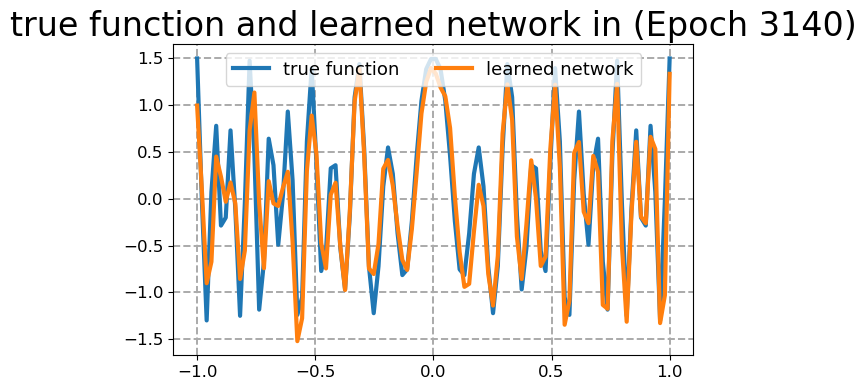

In [150]:
x = torch.linspace(-1, 1, 100,device=device)
y_true = func(x)


y_nn = learned_nn(x)


print(y_nn.shape)

fig=plt.figure(figsize=(6,4))
plt.plot(x.detach().cpu().numpy(), y_true.detach().cpu().numpy(), label='true function')
plt.plot(x.detach().cpu().numpy(), y_nn.detach().cpu().numpy(), label='learned network')
plt.xticks(np.linspace(*interval,5))
plt.tick_params(axis='both', 
                which='major', labelsize=12)
plt.grid(True, axis='both', color='#AAAAAA', 
            linestyle='--', linewidth=1.4)
plt.title(f'true function and learned network in (Epoch {epoch})')
plt.tight_layout()
plt.legend(loc="upper center" , fontsize=13,  ncol=2,
    )

plt.show()

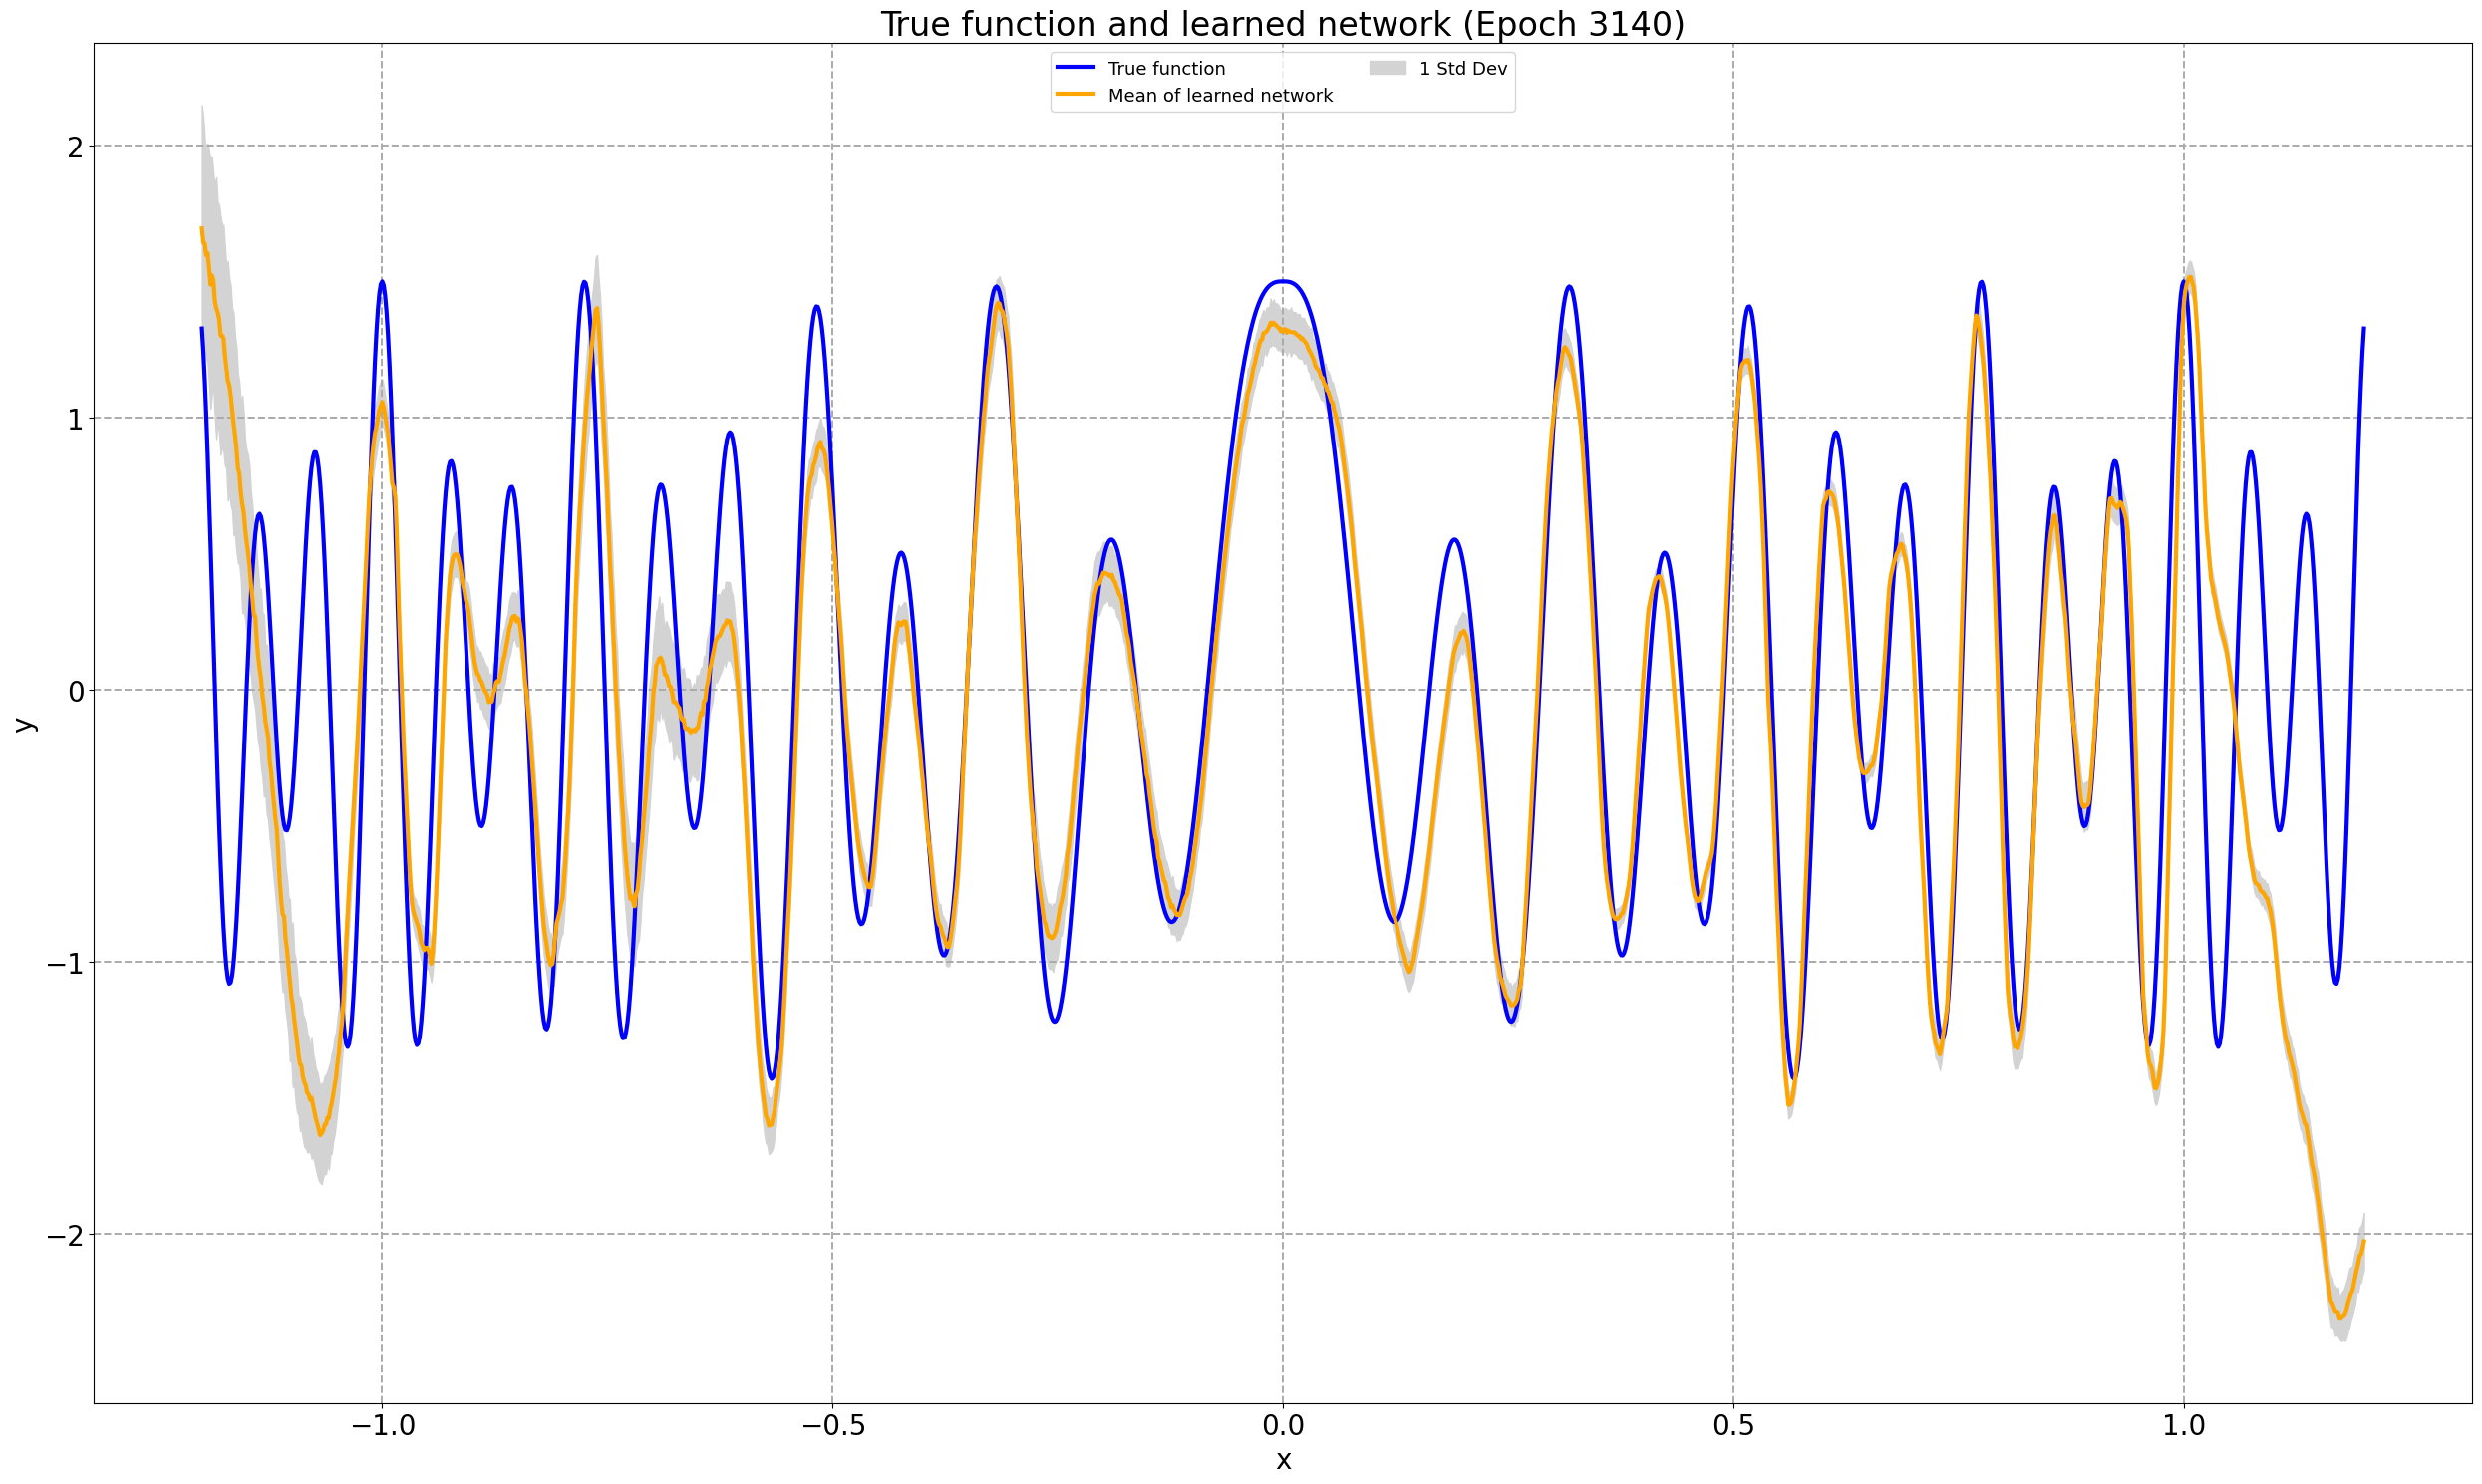

In [151]:
evaluation_points = 1500
x0 = -1.2
x1 = 1.2
x = torch.linspace(x0, x1, evaluation_points, device=device)#.view(-1, 1)
# x_data = torch.linspace(x0, x1, size_data_set, device=device)
y_true = func(x)



num_samples = 100

statistical_results = torch.zeros(num_samples, evaluation_points, device=device)
statistical_data = torch.zeros(num_samples, size_data_set, device=device)
y_nn,sigma_nn = model(x.view(-1,1), sigma_val=True)
statistical_results[0,:] = y_nn.reshape(-1)
for i in range(1,num_samples):
    y_nn = learned_nn(x)
    # y_nn_data = learned_nn(x_data)
    statistical_results[i,:] = y_nn.reshape(-1)
    # statistical_data[i,:] = y_nn_data.reshape(-1)

mean_y_nn = torch.mean(statistical_results, dim=0)
std_y_nn = torch.std(statistical_results, dim=0)
mean_y_nn_data = torch.mean(statistical_data, dim=0)
std_y_nn_data = torch.std(statistical_data, dim=0)

fig, ax = plt.subplots(figsize=(25, 15))
ax.plot(x.detach().cpu().numpy(), y_true.detach().cpu().numpy(), label='True function', color='blue')
ax.plot(x.detach().cpu().numpy(), mean_y_nn.detach().cpu().numpy(), label='Mean of learned network', color='orange')
# ax.plot(x_data.detach().cpu().numpy(), mean_y_nn_data.detach().cpu().numpy(), label='Mean of learned network (data)', color='green',marker ='o')
ax.fill_between(x.detach().cpu().numpy(), 
                (mean_y_nn - 2*std_y_nn).detach().cpu().numpy(), 
                (mean_y_nn + 2*std_y_nn).detach().cpu().numpy(), 
                color='lightgray', alpha=1, label='1 Std Dev')
# ax.fill_between(x_data.detach().cpu().numpy(), 
#                 (mean_y_nn_data - 1*std_y_nn_data).detach().cpu().numpy(), 
#                 (mean_y_nn_data + 1*std_y_nn_data).detach().cpu().numpy(), 
#                 color='lightgray', alpha=0.5, label='1 Std Dev (data)')
# Uncomment the following lines if you want to set x-axis limits and ticks
# ax.set_xlim(*interval)
# ax.set_xticks(np.linspace(*interval, 5))
ax.tick_params(axis='both', which='major', labelsize=20)
ax.grid(True, axis='both', color='#AAAAAA', linestyle='--', linewidth=1.4)
ax.set_title(f'True function and learned network (Epoch {epoch})')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(loc="upper center", fontsize=13, ncol=2)
plt.tight_layout()
plt.show()

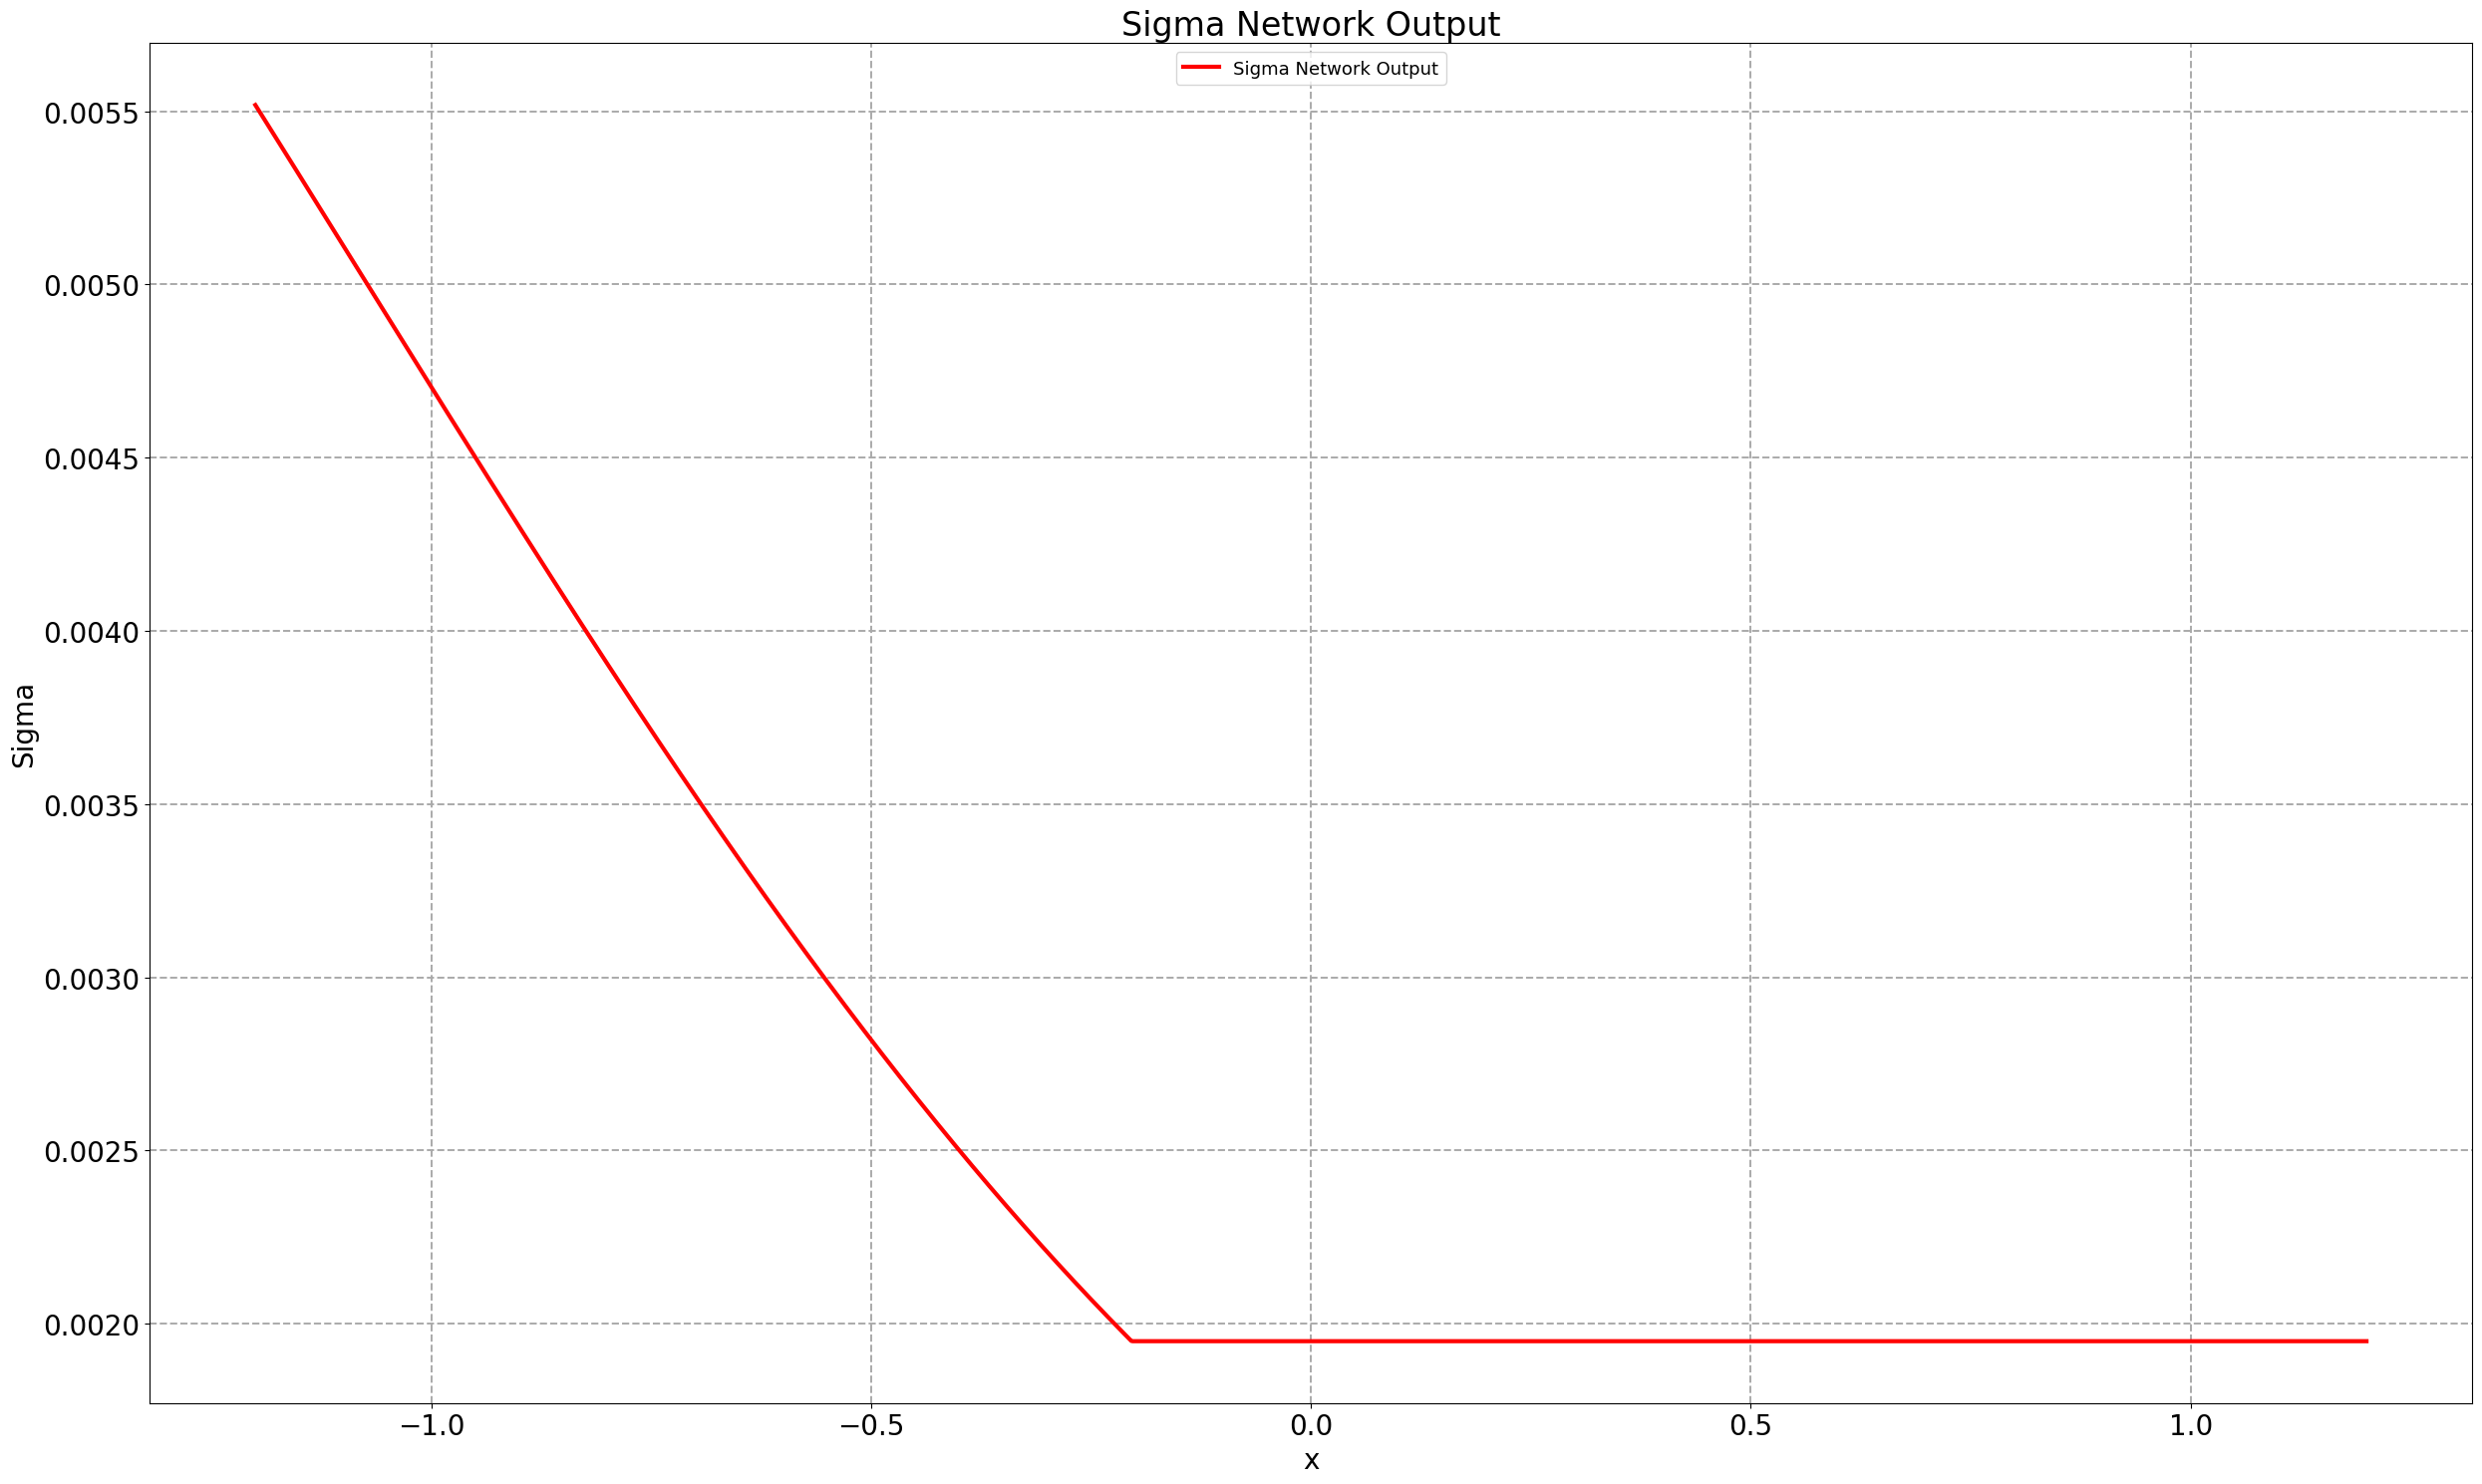

In [152]:
# Plot value of sigma_net

fig, ax = plt.subplots(figsize=(25, 15))
ax.plot(x.detach().cpu().numpy(), sigma_nn.detach().cpu().numpy(), label='Sigma Network Output', color='red')
ax.set_title('Sigma Network Output')
ax.set_xlabel('x')
ax.set_ylabel('Sigma')
ax.tick_params(axis='both', which='major', labelsize=20)
ax.grid(True, axis='both', color='#AAAAAA', linestyle='--', linewidth=1.4)
ax.legend(loc="upper center", fontsize=13, ncol=2)
plt.tight_layout()
plt.show()